Using CPU for training


100.0%
100.0%
100.0%
100.0%


Number of training samples: 60000
Number of test samples: 10000
Shape of one batch of images: torch.Size([64, 1, 28, 28])
Shape of one batch of labels: torch.Size([64])


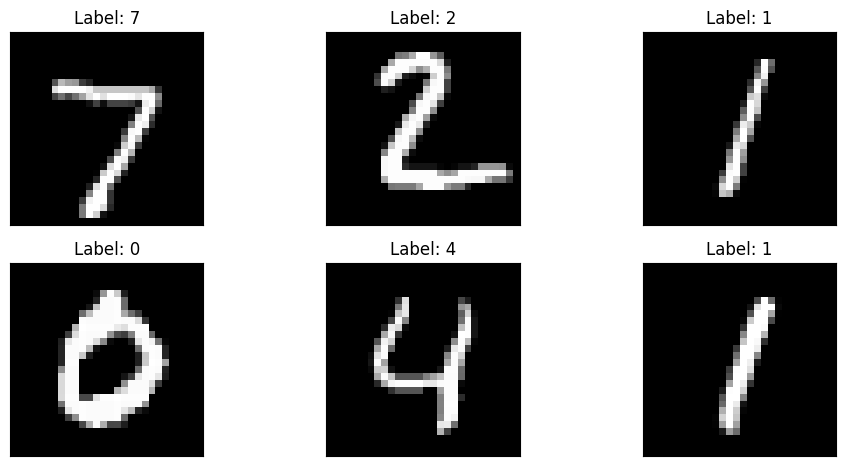

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Device Config
if torch.cuda.is_available():
    device="cuda"
    print("Using GPU for training")
else:
    device="cpu"
    print("Using CPU for training")

#Hyperparameters
input_size=28*28
hidden_size=128
num_classes=10
num_epochs=10
batch_size=64
learning_rate=0.001

# MINST dataset loading and transformation
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)) # mean and Std dev of dataset, Z-Score Normalization
])

#Training Data
train_dataset=datasets.MNIST(root='./data',train=True, transform=transform,download=True)
train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

#Testing Data
test_dataset=datasets.MNIST(root='./data',train=False,transform=transform,download=True)
test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Example of the Data we have
examples=enumerate(test_loader)
batch_idx, (example_data,example_targets)=next(examples)

print(f"Shape of one batch of images: {example_data.shape}") # Should be [batch_size, 1, 28, 28]
print(f"Shape of one batch of labels: {example_targets.shape}") # Should be [batch_size]

#Visualizing a few images
fig = plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    # For plotting, we need to remove the channel dimension (1) and denormalize
    img = example_data[i][0] * 0.3081 + 0.1307 # Denormalize
    plt.imshow(img.cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f"Label: {example_targets[i].item()}")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [2]:
class MLP(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(MLP,self).__init__()
        self.fc1=nn.Linear(input_size,hidden_size)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(hidden_size,hidden_size)
        self.fc3=nn.Linear(hidden_size,num_classes)

    def forward(self,x):
        # Flatten the input img from 28X28 to 784
        x=x.view(x.size(0),-1)
        
        #forward pass
        out=self.fc1(x)
        out=self.relu(out)
        out=self.fc2(out)
        out=self.relu(out)
        out=self.fc3(out)

        return out

model=MLP(input_size,hidden_size,num_classes).to(device)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
#Loss function and optimizer

criterion=nn.CrossEntropyLoss()

optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")


Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [4]:
loss_history=[]
train_accuracy_history=[]

print("Starting Training")
for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    correct_predictions=0
    total_predictions=0

    for batch_idx,(images,labels) in enumerate(train_loader):
        images=images.to(device)
        labels=labels.to(device)

        outputs=model(images)

        loss=criterion(outputs,labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()*images.size(0)

        _,predicted=torch.max(outputs.data,1)
        total_predictions+=labels.size(0)
        correct_predictions+=(predicted==labels).sum().item()
    
    epoch_loss=running_loss/len(train_dataset)
    epoch_accuracy=correct_predictions/total_predictions

    loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {epoch_loss:.4f}, '
          f'Accuracy: {epoch_accuracy*100:.2f}%')
print("Training Finished")
        


Starting Training
Epoch [1/10], Loss: 0.2551, Accuracy: 92.26%
Epoch [2/10], Loss: 0.1053, Accuracy: 96.74%
Epoch [3/10], Loss: 0.0732, Accuracy: 97.66%
Epoch [4/10], Loss: 0.0595, Accuracy: 98.07%
Epoch [5/10], Loss: 0.0461, Accuracy: 98.47%
Epoch [6/10], Loss: 0.0399, Accuracy: 98.67%
Epoch [7/10], Loss: 0.0314, Accuracy: 98.99%
Epoch [8/10], Loss: 0.0262, Accuracy: 99.09%
Epoch [9/10], Loss: 0.0256, Accuracy: 99.13%
Epoch [10/10], Loss: 0.0235, Accuracy: 99.21%
Training Finished



Accuracy of the model on the 10000 test images: 97.45%


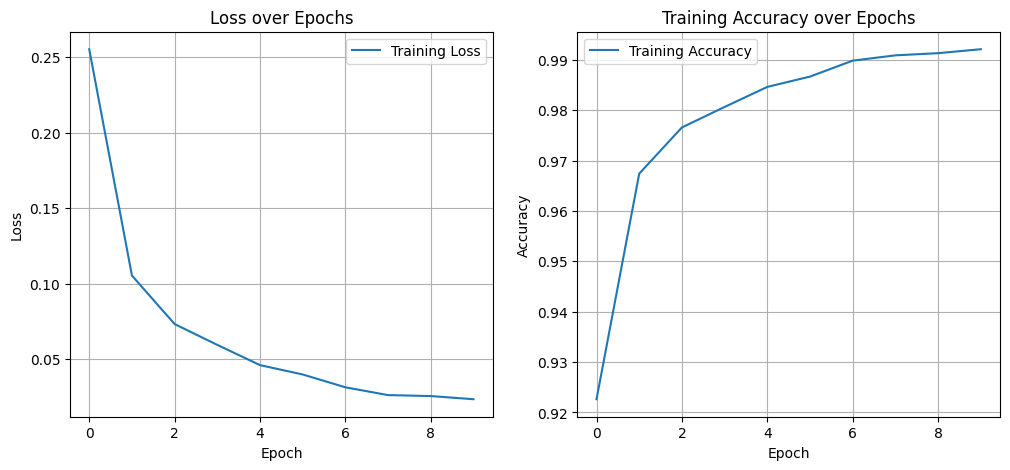

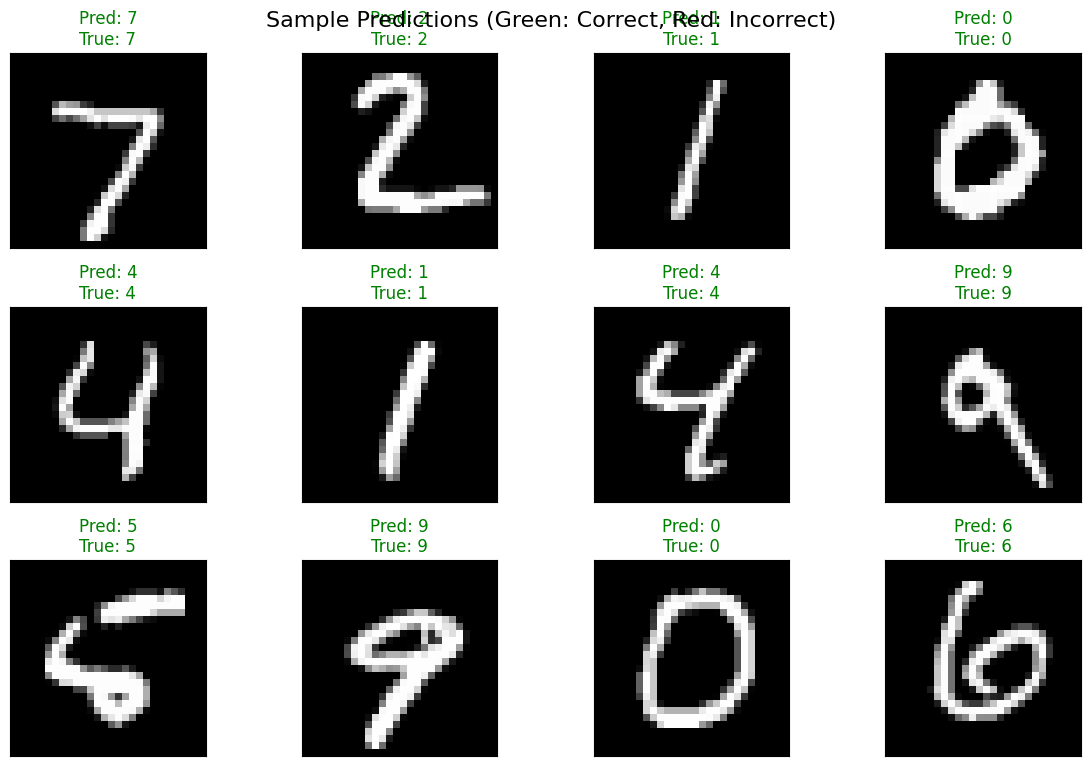

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [5]:
# Evaluate the model on the test data
model.eval()
with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f'\nAccuracy of the model on the {total} test images: {test_accuracy*100:.2f}%')

# Plot the loss and accuracy history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Visualizing some predictions (optional)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
model.cpu() 
outputs = model(example_data)
_, predictions = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    img = example_data[i][0] * 0.3081 + 0.1307 
    plt.imshow(img.numpy(), cmap='gray', interpolation='none')
    color = 'green' if predictions[i].item() == example_targets[i].item() else 'red'
    plt.title(f"Pred: {predictions[i].item()}\nTrue: {example_targets[i].item()}", color=color)
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Sample Predictions (Green: Correct, Red: Incorrect)', fontsize=16)
plt.show()

model.to(device) # Move model back to original device if needed for further operations